In [ ]:
!pip install torch transformers dvc dvc-gs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.3/430.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.0/422.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.0/200.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install transformers --upgrade

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 21.7 MB/s eta 0:00:00


In [ ]:
# Log in to W&B account
import wandb

In [ ]:
wandb.init(project="bloom_fine_tuning_v3", entity="ac215-the-prescribers")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
import transformers
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import (
    BloomTokenizerFast,
    BloomForSequenceClassification,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from google.colab import auth, drive
import matplotlib.pyplot as plt

In [ ]:
auth.authenticate_user()

In [ ]:
# Load the teacher model
!mkdir -p /content/finetuned_model
!gsutil -m cp -r "gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/*" "/content/finetuned_model/"
teacher_model_path = "/content/finetuned_model"
tokenizer = BloomTokenizerFast.from_pretrained(teacher_model_path, repo_type="local")
teacher_model = BloomForSequenceClassification.from_pretrained(teacher_model_path)

Copying gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/config.json...
Copying gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/pytorch_model.bin...
Copying gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/tokenizer.json...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/special_tokens_map.json...
Copying gs://finetunned_760m_bloom/bloom_icd_10/finetuned_model/tokenizer_config.json...
/ [5/5 files][  4.0 GiB/  4.0 GiB] 100% Done  36.1 MiB/s ETA 00:00:00           
Operation completed over 5 objects/4.0 GiB.                                      


In [ ]:
#load the data
!gcloud config set project 'steel-climber-398320'
!gsutil cp gs://training_dataset_bloom/merged_symp_icd/symptoms_icd10.json ./training_data.jsonl
training_data = pd.read_json('training_data.jsonl', lines=True)

Updated property [core/project].
Copying gs://training_dataset_bloom/merged_symp_icd/symptoms_icd10.json...
- [1 files][625.7 KiB/625.7 KiB]                                                
Operation completed over 1 objects/625.7 KiB.                                    


In [ ]:
label_encoder = LabelEncoder()
training_data ['encoded_labels'] = label_encoder.fit_transform(training_data['icd10_code'])

In [ ]:
train_data, test_data = train_test_split(training_data, test_size=0.1)

In [ ]:
# reset the indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
class AdvancedNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim, lstm_layers, bidirectional):
        super(AdvancedNN, self).__init__()
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=lstm_layers, batch_first=True, bidirectional=bidirectional)
        lstm_output_size = hidden_dim * 2 if bidirectional else hidden_dim

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_output_size, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        # Reshape x to be 3-dimensional for LSTM input
        # Assuming x is originally 2-dimensional (batch_size, sequence_length)
        x = x.unsqueeze(-1)

        # LSTM layer
        x, _ = self.lstm(x)

        # Take the output of the last LSTM time step
        x = x[:, -1, :]  # Assuming x is 3D and this is valid

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x


In [ ]:
input_size = 1536 #must change to be relative
hidden_dim = 512 #must change to be relative
lstm_layers = 2 #must change to be relative
bidirectional = True
num_classes = train_data['icd10_code'].nunique()

student_model = AdvancedNN(input_size, num_classes, hidden_dim, lstm_layers, bidirectional)

In [ ]:
#class SimpleNN(nn.Module):
#    def __init__(self, input_size, num_classes):
#        super(SimpleNN, self).__init__()
#        self.fc1 = nn.Linear(input_size, 512)
#        self.relu = nn.ReLU()
#        self.fc2 = nn.Linear(512, num_classes)  # Output layer
#
#    def forward(self, x):
#        out = self.fc1(x)
#        out = self.relu(out)
#        out = self.fc2(out)
#        return out

# Assuming input size and number of classes are known
#input_size = 1536
#num_classes = train_data['icd10_code'].nunique()
#student_model = SimpleNN(input_size, num_classes)
# model is by default on CPU


In [ ]:
#train_data

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=1536):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Encode string labels to integers
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )
        input_ids = encoded['input_ids'].flatten()

        # Ensure input_ids is the correct shape
        if len(input_ids) != self.max_length:
            padding = [0] * (self.max_length - len(input_ids))
            input_ids = torch.cat((input_ids, torch.tensor(padding)), dim=0)

        # Fetch the corresponding encoded label
        label = self.encoded_labels[idx]

        return input_ids, label

In [ ]:
train_dataset = CustomDataset(train_data['symptoms'], train_data['icd10_code'], tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)


In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss() #this is important to have the implicit softmax in pythoch
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

In [ ]:
train_data.reset_index(drop=True, inplace=True)

In [ ]:
num_epochs = 3

for epoch in range(num_epochs):
    for batch in train_dataloader:
        print("Epoch:",epoch )

        input_ids, labels = batch

        # Ensure input_ids and labels are of the correct type
        input_ids = input_ids.float()
        labels = torch.tensor(labels, dtype=torch.long)

        # Forward pass
        outputs = student_model(input_ids)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



Epoch: 0


<ipython-input-24-46256ea0a900>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 2
Epoch: 2
Epoch: 2
Epoch: 2
Epoch: 2


In [ ]:
# Prepare validation dataset
test_dataset = CustomDataset(test_data['symptoms'], test_data['icd10_code'], tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [ ]:
# Validation Function
def validate(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids = input_ids.float()
            labels = torch.tensor(labels, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [ ]:
# Training loop with validation
num_epochs = 15

#this is for plotting
train_losses, val_losses, val_accuracies = [], [], []

In [29]:
for epoch in range(num_epochs):
    # Training
    student_model.train()
    for batch in train_dataloader:
        input_ids, labels = batch
        input_ids = input_ids.float()
        labels = torch.tensor(labels, dtype=torch.long)

        # Forward pass
        outputs = student_model(input_ids)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    val_loss, val_accuracy = validate(student_model, test_dataloader, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # append to lists for plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


<ipython-input-29-8dbca6733330>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-26-8be88d4013d0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch [1/15], Loss: 6.3526, Validation Loss: 7.3977, Validation Accuracy: 0.0069
Epoch [2/15], Loss: 6.4890, Validation Loss: 7.5696, Validation Accuracy: 0.0000
Epoch [3/15], Loss: 6.1413, Validation Loss: 7.5523, Validation Accuracy: 0.0000
Epoch [4/15], Loss: 6.3659, Validation Loss: 7.6312, Validation Accuracy: 0.0000
Epoch [5/15], Loss: 6.3198, Validation Loss: 8.0121, Validation Accuracy: 0.0000
Epoch [6/15], Loss: 6.2487, Validation Loss: 8.0515, Validation Accuracy: 0.0000
Epoch [7/15], Loss: 6.2873, Validation Loss: 8.1383, Validation Accuracy: 0.0000
Epoch [8/15], Loss: 6.1810, Validation Loss: 8.0566, Validation Accuracy: 0.0069
Epoch [9/15], Loss: 6.0668, Validation Loss: 8.3330, Validation Accuracy: 0.0069
Epoch [10/15], Loss: 6.0910, Validation Loss: 8.3291, Validation Accuracy: 0.0069
Epoch [11/15], Loss: 6.1168, Validation Loss: 8.5263, Validation Accuracy: 0.0069
Epoch [12/15], Loss: 6.4085, Validation Loss: 8.6724, Validation Accuracy: 0.0069
Epoch [13/15], Loss: 6.25

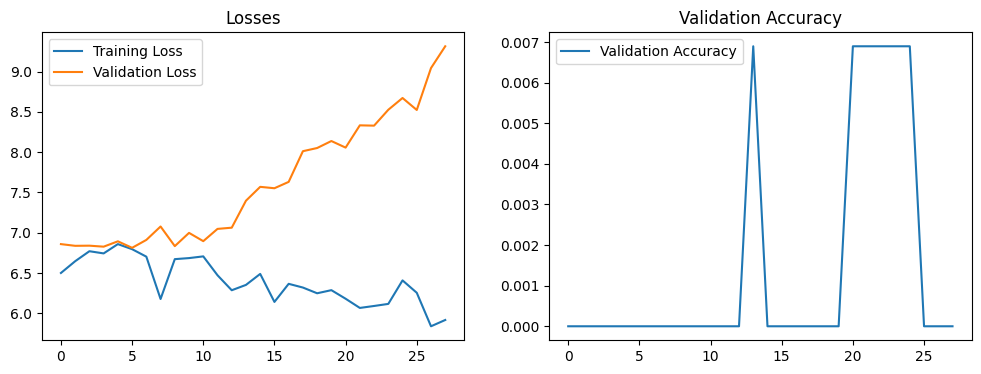

In [30]:
#plot the training of the model
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [31]:
## prompt to test the student model
test_prompt = "i have red spots in my face"

In [32]:
# Tokenize the test prompt
encoded_test_prompt = tokenizer.encode_plus(
    test_prompt,
    add_special_tokens=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True,
    max_length=1536
)
input_ids_test = encoded_test_prompt['input_ids'].flatten()

# Ensure the input is the correct shape
input_ids_test = input_ids_test.unsqueeze(0)


In [33]:
# make sure the student model is in evaluation mode
student_model.eval()

with torch.no_grad():
    # Forward pass
    output = student_model(input_ids_test.float())
    prediction = torch.argmax(output, dim=1)
    predicted_label = label_encoder.inverse_transform(prediction.numpy())

print("Predicted Label:", predicted_label[0])


Predicted Label: Q8711


In [34]:
#first save the model locally
save_directory = "/content/distilled_model"
torch.save(student_model.state_dict(), save_directory)

In [35]:
#save the model in a bucket in GCP
!gsutil cp -r /content/distilled_model gs://finetunned_destillation/destilled_bloom_icd_10/

Copying file:///content/distilled_model [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/63.5 MiB.                                     
